# Pipeline analysis for supervised data
Let's start simple by analyzing the data from a single individual, considering: total distance, look-around, sniffing, inner-zone time, wall-climbing, and huddle. We start by importing the necessary packages and directories.

In [2]:
import os
import pandas as pd
import pickle
import deepof.data
import deepof.visuals
import visuals_customized
import seaborn as sns
import matplotlib.pyplot as plt

2024-02-06 11:37:24.404909: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-06 11:37:24.404954: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-06 11:37:24.406182: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-06 11:37:24.413579: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-06 11:37:25.089388: W tensorflow/compiler/tf2

In [3]:
# Open an existing DeepOF project
directory_output = '//home/sie/Desktop/marc/brain_01a02/'
my_deepof_project = deepof.data.load_project(directory_output + "deepof_tutorial_project")

In [4]:
# Open an existing supervised analysis
with open(directory_output + 'supervised_annotation.pkl', 'rb') as file:
    supervised_annotation = pickle.load(file)

In [5]:
# Load conditions
my_deepof_project.load_exp_conditions(directory_output + 'conditions.csv')

In [6]:
# Define colors
white = '#FFFFFF'
grey_soft = '#D3D3D3'
grey_stark = '#636466'
blue = '#194680'
red = '#801946'

## Plot PCA between conditions

In [ ]:
# Define the coordinates for the labels of each condition
coords_dict = {
    'hc_ind': ['name1', [4,5]],
    'hc_ee': ['name2', [4,5]],
    }

In [ ]:
# Define the colors for each condition
color_dict = {
    'hc_ind': sns.color_palette("Set1")[0],,
    'hc_ee': sns.color_palette("Set1")[1],
    }

In [ ]:
ax, embedding_dataset, rotated_loading_scores, dataframe_for_titles = visuals_customized.plot_embeddings(
    my_deepof_project,
    supervised_annotations=supervised_annotation,
    bin_size=120,
    bin_index=0,
    my_title = 'PCA first time bin',
    my_color_dict = color_dict,
    my_coords_dict = coords_dict
)

### Analyze individual PC and rotated_loading_scores

In [ ]:
# Perform statistics
import pingouin as pg
pg.normality(embedding_dataset, 'PCA-2', 'experimental condition')
pg.homoscedasticity(embedding_dataset, 'PCA-2', 'experimental condition')

x = embedding_dataset[embedding_dataset['experimental condition'] == 'hc_ee']['PCA-2']
y = embedding_dataset[embedding_dataset['experimental condition'] == 'hc_ind']['PCA-2']
pg.ttest(x, y).round(3)

# pg.anova(embedding_dataset, 'PCA-1', 'experimental condition')
# pg.pairwise_tukey(embedding_dataset, 'PCA-1', 'experimental condition')

In [ ]:
# Save your statistics in a dictionary
stats_dict = {
    '*': ['hc_ee', 'hc_ind']
    }

In [ ]:
# Plot the PC components
visuals_customized.boxplot(embedding_dataset, color_dict, 'PCA-1', stats_dict)

In [ ]:
# Plot the rotated loading scores of PC components
visuals_customized.lollipop(dataframe_for_titles, rotated_loading_scores, 'PCA-1')

## Plot PCA between time points

In [29]:
# Define the coordinates for the labels of each condition
coords_dict = {
#    'bin0': ['name1', [4,5]],
#    'bin1': ['name2', [4,5]],
    'bin2': ['Before tone', [-4,5]],
    'bin3': ['During tone', [4,3.5]],
    }

In [8]:
# Define the colors for each condition
color_dict = {
#    'bin0': sns.color_palette("Set1")[0],
#    'bin1': sns.color_palette("Set1")[1],
    'bin2': grey_stark,
    'bin3': blue
    }

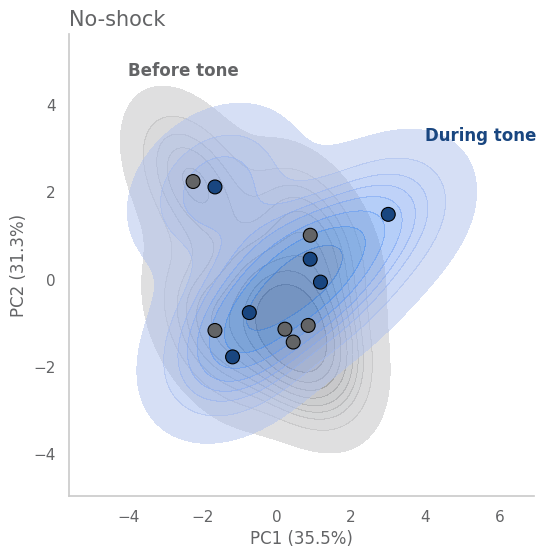

In [36]:
ax, embedding_dataset, rotated_loading_scores, dataframe_for_titles, concat_hue = visuals_customized.plot_embeddings_timelapse(
    my_deepof_project,
    supervised_annotations=supervised_annotation,
    bin_size=60,
    bin_index_list=[2,3],
    my_title = 'No-shock',
    my_color_dict = color_dict,
    my_coords_dict = coords_dict,
    specific_condition = 'noshock',
)

### Analyze individual PC, rotated_loading_scores (across time) 

In [37]:
# Perform statistics
import pingouin as pg
pg.normality(embedding_dataset, 'PCA-1', 'experimental condition')

,W,pval,normal
experimental condition,,,
bin2,0.820091,0.088413,True
bin3,0.931777,0.593891,True


In [38]:
pg.homoscedasticity(embedding_dataset, 'PCA-1', 'experimental condition')

,W,pval,equal_var
levene,0.742462,0.40906,True


In [39]:
x = embedding_dataset[embedding_dataset['experimental condition'] == 'bin2']['PCA-1']
y = embedding_dataset[embedding_dataset['experimental condition'] == 'bin3']['PCA-1']
pg.ttest(x, y).round(3)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.548,10,two-sided,0.595,"[-2.53, 1.53]",0.317,0.515,0.079


In [ ]:
pg.anova(embedding_dataset, 'PCA-1', 'experimental condition')
pg.pairwise_tukey(embedding_dataset, 'PCA-1', 'experimental condition')

In [40]:
# Save your statistics in a dictionary
stats_dict = {
    #'**': ['bin0', 'bin1'],
    #'***': ['bin0', 'bin2'],
    'ns': ['bin2', 'bin3'],
    }

<Axes: ylabel='PCA-1 eigenvalues'>

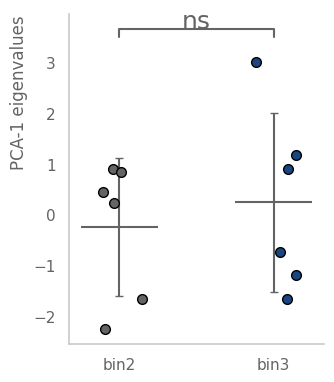

In [41]:
# Plot the PC components
visuals_customized.boxplot(embedding_dataset, color_dict, 'PCA-1', stats_dict)

<Axes: xlabel='PCA-1 rotated loading scores'>

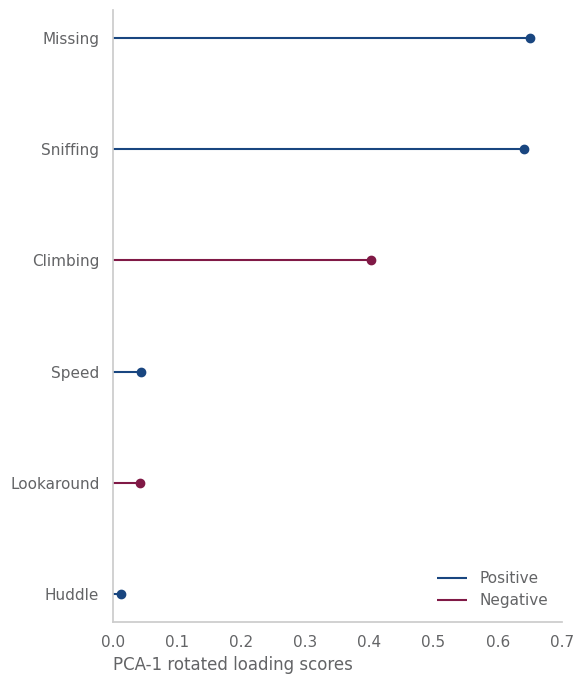

In [22]:
# Plot the rotated loading scores of PC components
visuals_customized.lollipop(dataframe_for_titles, rotated_loading_scores, 'PCA-1')

<Axes: xlabel='Time bins', ylabel='Huddle'>

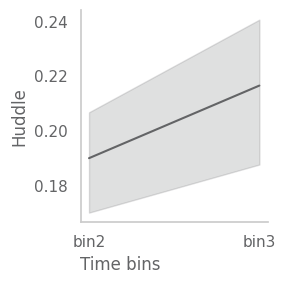

In [24]:
# Plot an individual behavior over bins
visuals_customized.timelapse(dataframe_for_titles, concat_hue, 'huddle')

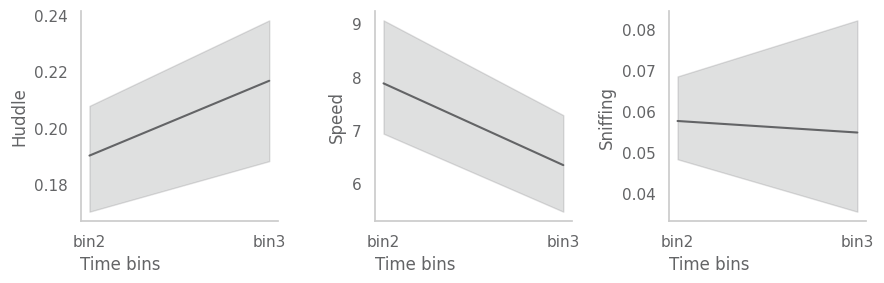

In [25]:
# Plot some individual behaviors over bins
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))

visuals_customized.timelapse(dataframe_for_titles, concat_hue, 'huddle', ax=ax1)
visuals_customized.timelapse(dataframe_for_titles, concat_hue, 'speed', ax=ax2)
visuals_customized.timelapse(dataframe_for_titles, concat_hue, 'sniffing', ax=ax3)

# ax1.set_title("supervised embeddings of full videos")
# ax2.set_title("supervised embeddings of first two minutes")

plt.tight_layout()
plt.show()